<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/Autoencoders/Simple%20Linear%20Autoencoders/MNIST/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

## Transform

In [2]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

## Load Data

In [3]:
# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,download=True, transform=transform)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Batching

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

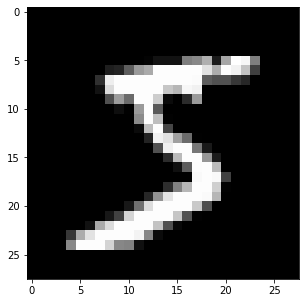

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## GPU Configure

In [6]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
gpu = torch.device('cuda:0')

1
Tesla T4


## Model Class

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.fc2(x))
        return x

In [9]:
# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
model = model.to(gpu)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


In [10]:
import copy

In [11]:
print(model.fc1)

Linear(in_features=784, out_features=32, bias=True)


In [12]:
init_weights = copy.deepcopy(model.fc1.weight.data)

In [13]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train Autoencoder

In [14]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        images = images.to(gpu)
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.746905
Epoch: 2 	Training Loss: 0.450480
Epoch: 3 	Training Loss: 0.417780
Epoch: 4 	Training Loss: 0.408426
Epoch: 5 	Training Loss: 0.402841
Epoch: 6 	Training Loss: 0.397333
Epoch: 7 	Training Loss: 0.392572
Epoch: 8 	Training Loss: 0.389433
Epoch: 9 	Training Loss: 0.387396
Epoch: 10 	Training Loss: 0.385899
Epoch: 11 	Training Loss: 0.384691
Epoch: 12 	Training Loss: 0.383683
Epoch: 13 	Training Loss: 0.382814
Epoch: 14 	Training Loss: 0.382049
Epoch: 15 	Training Loss: 0.381358
Epoch: 16 	Training Loss: 0.380643
Epoch: 17 	Training Loss: 0.380037
Epoch: 18 	Training Loss: 0.379523
Epoch: 19 	Training Loss: 0.379062
Epoch: 20 	Training Loss: 0.378644


## Checking out the results

In [15]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

In [16]:
print(images.shape)

torch.Size([20, 1, 28, 28])


In [17]:
print(images.shape[0])

20


In [18]:
print(images.view(images.size(0), -1).shape)

torch.Size([20, 784])


In [19]:
images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten.to(gpu))
# prep images for display
images = images.numpy()

In [20]:
# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

In [21]:
print(images.shape, output.shape,np.squeeze(images[0]).shape )

(20, 1, 28, 28) (20, 1, 28, 28) (28, 28)


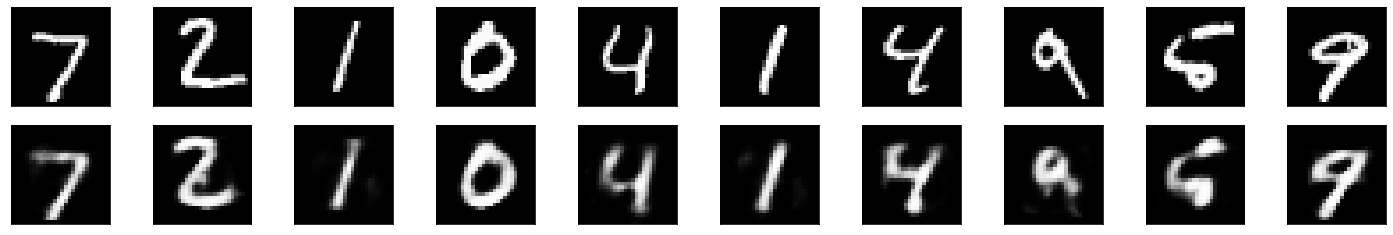

In [22]:
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Encoder Weights Visualization

In [23]:
trained_weights = copy.deepcopy(model.fc1.weight.data)

In [24]:
trained_weights.shape

torch.Size([32, 784])

In [25]:
init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5

In [26]:
print(init_weights.view(-1,28,28).shape)

torch.Size([32, 28, 28])


In [27]:
init_weights = init_weights.view(-1,28,28).byte().cpu()
trained_weights = trained_weights.view(-1,28,28).byte().cpu()

In [28]:
d_weights = init_weights - trained_weights 

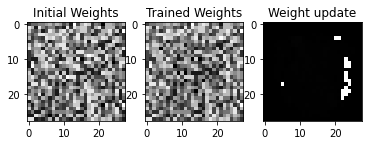

In [29]:
fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()